In [132]:
%tensorflow_version 1.x


from google.colab import drive 


In [133]:
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [134]:
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt

import os
from PIL import Image
import tensorflow as tf
from tensorflow.python.framework import ops


In [135]:
DIRECTORY = r"/content/drive/MyDrive/dataset"
CATEGORIES = ["with_mask", "without_mask"]

In [136]:

def load_dataset():
    x_list=[]
    y_list=[]
    class_list=[]
    path1 = os.path.join(DIRECTORY,CATEGORIES[0])
    path2 = os.path.join(DIRECTORY,CATEGORIES[1])
    list1=os.listdir(path1)
    list2=os.listdir(path2)
    for img1,img2 in zip(list1,list2):
        img_path1 = os.path.join(path1, img1)
        image1=Image.open(img_path1)
        image1 = image1.resize((64,64))
        image1 =np.array( image1)
        img_path2 = os.path.join(path2, img2)
        image2 = Image.open(img_path2)
        image2 = image2.resize((64, 64))
        image2 = np.array(image2)
        x_list.append(image1)
        x_list.append(image2)
        y_list.append([1])
        y_list.append([0])
        class_list.append(CATEGORIES[0])
        class_list.append(CATEGORIES[1])
        if ( len (x_list) > 249):    #to limit the number ( crappy PC)
            return (x_list,y_list,class_list)


In [137]:

def data_flat_split():
    x_list, y_list, class_list = load_dataset()

    print(len(x_list), " --", len(y_list), "----", len(class_list))

    print(x_list[0].shape)
    print(x_list[1].shape)
    print(x_list[100].shape)
    train_set_x_orig= np.array(x_list[0:209])
    train_set_y = np.array(y_list[0:209]).T
    train_classes=np.array(class_list[0:209])
    test_set_x_orig = np.array( x_list[209:])
    test_set_y = np.array(y_list[209:]).T
    test_classes = np.array(class_list[209:])

    train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T/255.
    test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T/255.
    train_set_y = convert_to_one_hot(train_set_y, 2)
    test_set_y = convert_to_one_hot(test_set_y, 2)
    return (train_set_x_flatten,test_set_x_flatten,train_set_y,test_set_y,train_classes,test_classes)



In [138]:
train_set_x_flatten,test_set_x_flatten,train_set_y,test_set_y,train_classes,test_classes=data_flat_split()

print ( train_set_x_flatten.shape,"---",train_set_y.shape)

250  -- 250 ---- 250
(64, 64, 3)
(64, 64, 3)
(64, 64, 3)
(12288, 209) --- (2, 209)


In [139]:

def random_mini_batches(X, Y, mini_batch_size=64, seed=0):
    """
    Creates a list of random minibatches from (X, Y)

    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.

    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """

    m = X.shape[1]  # number of training examples
    mini_batches = []
 

    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0], m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(
        m / mini_batch_size)  # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size: k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size: m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)

    return mini_batches

In [140]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y
    

In [141]:

def predict(X, parameters):
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])

    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}

    x = tf.placeholder("float", [12288, 1])

    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)

    sess = tf.Session()
    prediction = sess.run(p, feed_dict={x: X})

    return prediction

In [142]:

def forward_propagation_for_predict(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX

    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters
    Returns:
    Z3 -- the output of the last LINEAR unit
    """

    # Retrieve the parameters from the dictionary "parameters"
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)  # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)  # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)  # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)  # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)  # Z3 = np.dot(W3,Z2) + b3

    return Z3

In [143]:

# GRADED FUNCTION: sigmoid

def sigmoid(z):
    """
    Computes the sigmoid of z

    Arguments:
    z -- input value, scalar or vector

    Returns:
    results -- the sigmoid of z
    """

    ### START CODE HERE ### ( approx. 4 lines of code)
    # Create a placeholder for x. Name it 'x'.
    x = tf.placeholder(tf.float32, name="x")

    # compute sigmoid(x)
    sigmoid = tf.sigmoid(x)

    # Create a session, and run it. Please use the method 2 explained above.
    # You should use a feed_dict to pass z's value to x.
    with tf.Session() as sess:
        # Run session and call the output "result"
        result = result = sess.run(sigmoid, feed_dict={x: z})

    ### END CODE HERE ###

    return result

In [144]:

# GRADED FUNCTION: cost

def cost(logits, labels):
    """
    Computes the cost using the sigmoid cross entropy

    Arguments:
    logits -- vector containing z, output of the last linear unit (before the final sigmoid activation)
    labels -- vector of labels y (1 or 0)

    Note: What we've been calling "z" and "y" in this class are respectively called "logits" and "labels"
    in the TensorFlow documentation. So logits will feed into z, and labels into y.

    Returns:
    cost -- runs the session of the cost (formula (2))
    """

    ### START CODE HERE ###

    # Create the placeholders for "logits" (z) and "labels" (y) (approx. 2 lines)
    z = tf.placeholder(tf.float32, name="z")
    y = tf.placeholder(tf.float32, name="y")

    # Use the loss function (approx. 1 line)
    cost = tf.nn.sigmoid_cross_entropy_with_logits(logits=z, labels=y)

    # Create a session (approx. 1 line). See method 1 above.
    sess = tf.Session()

    # Run the session (approx. 1 line).
    cost = sess.run(cost, feed_dict={z: logits, y: labels})

    # Close the session (approx. 1 line). See method 1 above.
    sess.close()

    ### END CODE HERE ###

    return cost

In [145]:

# GRADED FUNCTION: one_hot_matrix

def one_hot_matrix(labels, C):
    """
    Creates a matrix where the i-th row corresponds to the ith class number and the jth column
                     corresponds to the jth training example. So if example j had a label i. Then entry (i,j)
                     will be 1.

    Arguments:
    labels -- vector containing the labels
    C -- number of classes, the depth of the one hot dimension

    Returns:
    one_hot -- one hot matrix
    """

    ### START CODE HERE ###

    # Create a tf.constant equal to C (depth), name it 'C'. (approx. 1 line)
    C = tf.constant(C, name='C')

    # Use tf.one_hot, be careful with the axis (approx. 1 line)
    one_hot_matrix = tf.one_hot(indices=labels, depth=C, axis=0)

    # Create the session (approx. 1 line)
    sess = tf.Session()

    # Run the session (approx. 1 line)
    one_hot = sess.run(one_hot_matrix)

    # Close the session (approx. 1 line). See method 1 above.
    sess.close()

    ### END CODE HERE ###

    return one_hot


In [146]:

# GRADED FUNCTION: ones

def ones(shape):
    """
    Creates an array of ones of dimension shape

    Arguments:
    shape -- shape of the array you want to create

    Returns:
    ones -- array containing only ones
    """

    ### START CODE HERE ###

    # Create "ones" tensor using tf.ones(...). (approx. 1 line)
    ones = tf.ones(shape)

    # Create the session (approx. 1 line)
    sess = tf.Session()

    # Run the session to compute 'ones' (approx. 1 line)
    ones = sess.run(ones)

    # Close the session (approx. 1 line). See method 1 above.
    sess.close()

    ### END CODE HERE ###
    return ones



In [147]:

# GRADED FUNCTION: create_placeholders

def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.

    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)

    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"

    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, [n_x, None], name="X")
    Y = tf.placeholder(tf.float32, [n_y, None], name="Y")
    ### END CODE HERE ###

    return X, Y


In [148]:

def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [2, 12]
                        b3 : [2, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25, 12288], initializer = tf.contrib.layers.xavier_initializer())
    b1 = tf.get_variable("b1", [25, 1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer())
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [2, 12], initializer = tf.contrib.layers.xavier_initializer())
    b3 = tf.get_variable("b3", [2, 1], initializer = tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [149]:
# GRADED FUNCTION: forward_propagation

def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [150]:
# GRADED FUNCTION: compute_cost 

def compute_cost(Z3, Y):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    ### START CODE HERE ### (1 line of code)
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=labels))
    ### END CODE HERE ###
    
    return cost


In [151]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
   
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

Cost after epoch 0: 0.900098
Cost after epoch 100: 0.027842
Cost after epoch 200: 0.006596
Cost after epoch 300: 0.002732
Cost after epoch 400: 0.001391
Cost after epoch 500: 0.000739
Cost after epoch 600: 0.000451
Cost after epoch 700: 0.000268
Cost after epoch 800: 0.000173
Cost after epoch 900: 0.000108
Cost after epoch 1000: 0.000066
Cost after epoch 1100: 0.000044
Cost after epoch 1200: 0.000029
Cost after epoch 1300: 0.000020
Cost after epoch 1400: 0.000012


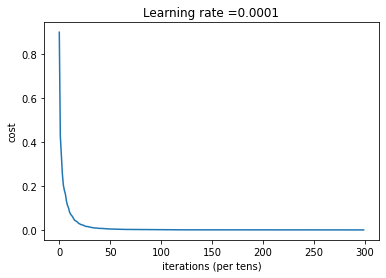

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.9756098


In [152]:
parameters = model(train_set_x_flatten, train_set_y,test_set_x_flatten,test_set_y)


(64, 64, 3)
(12288, 1)
Your algorithm predicts: y = 0


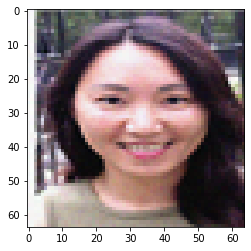

In [177]:
import scipy
from PIL import Image
from scipy import ndimage

path = "/content/drive/MyDrive/images/augmented_image_103.jpg"

image=Image.open(path)

image = image.resize((64, 64))

image =np.array( image)
print (image.shape)

my_image= image.reshape ((1, 64 * 64 * 3)).T
print (my_image.shape)

my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))